In [3]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df = pd.read_excel('C:\\Users\\elif.ozkol\\Desktop\\LSE Project\\CleanedDataUK.xlsx')

df

,Reference,Country,Date,Year,Month,Title,Author,IsGov,Text
0,r980915a_BOE,United Kingdom,1998-09-15,1998,September,Speech,George,Yes,"Thank you, Chairman. I'm actually very pleased..."
1,r981021b_BOE,United Kingdom,1998-10-21,1998,October,Britain in Europe,George,Yes,It's a great pleasure to be here in the beauti...
2,r981021a_BOE,United Kingdom,1998-10-21,1998,October,Impact of the recent turbulence in internation...,King,No,Few industries have suffered more from volatil...
3,r981101a_BOE,United Kingdom,1998-11-01,1998,November,"Economic policy, with and without forecasts",Budd,No,My topic this evening is the use of forecasts ...
4,r981101b_BOE,United Kingdom,1998-11-01,1998,November,Inflation targeting in practice: the UK experi...,Vickers,No,"Six years ago this week, sterling left the exc..."
...,...,...,...,...,...,...,...,...,...
1204,r220428a_BOE,United Kingdom,2022-04-28,2022,April,Macropru,Breeden,No,Dimitri Demekas and Paul Tucker for helpful di...
1205,r220426a_BOE,United Kingdom,2022-04-26,2022,April,Bufferati,Woods,No,Copies of publications are available from: Thi...
1206,r220503a_BOE,United Kingdom,2022-05-03,2022,May,Why macroprudential policy needs to tackle fin...,Stheeman,No,Elisabeth Stheeman notes that climate change a...
1207,r221019a_BOE,United Kingdom,2022-10-19,2022,October,"Governance of “Decentralised” Finance: Get up,...",Wilkins,No,"These are divided into seven categories, suffr..."


In [5]:
# Create a new data frame for the file sentiment labelled wordlist

df_sentiment_words = pd.read_excel('C:\\Users\\elif.ozkol\\Desktop\\LSE Project\\LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx')

df_sentiment_words

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3875,WRONGDOINGS,1,0,0,0,0,0,0
3876,WRONGFUL,1,0,0,0,0,0,0
3877,WRONGFULLY,1,0,0,0,0,0,0
3878,WRONGLY,1,0,0,0,0,0,0


*Strategy for Mapping to VADER Scores
Since VADER uses a single float value per word, we’ll map your multiple labels to a weighted score. Here's a suggested scoring scheme (you can adjust weights as needed):

Feature	Contribution to Score
Positive	+2.0

Negative	-2.0

Uncertainty	-0.5

Litigious	-0.3

Strong	+1.0

Weak	-1.0

Constraining	-0.5*

**Build the Custom Lexicon**

In [6]:
# Force all entries in 'Word' column to strings, skipping bad ones
df_sentiment_words = df_sentiment_words[df_sentiment_words['Word'].apply(lambda x: isinstance(x, str))]

df_sentiment_words


,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3874,WRONGDOING,1,0,0,0,0,0,0
3875,WRONGDOINGS,1,0,0,0,0,0,0
3876,WRONGFUL,1,0,0,0,0,0,0
3877,WRONGFULLY,1,0,0,0,0,0,0


In [7]:
custom_lexicon = {}

for _, row in df_sentiment_words.iterrows():
    word = row['Word'].lower()
    
    # Weighted score based on categories
    score = (
        row['Positive'] * 2.0 +
        row['Negative'] * -2.0 +
        row['Uncertainty'] * -0.5 +
        row['Litigious'] * -0.3 +
        row['Strong'] * 1.0 +
        row['Weak'] * -1.0 +
        row['Constraining'] * -0.5
    )
    
    # Only include non-zero scores
    if score != 0:
        custom_lexicon[word] = score


In [8]:
 ##custom_lexicon

**Integrate into VADER**

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(custom_lexicon)



**Apply sentiment analysis**

In [10]:
# Apply VADER to each speech
df['Sentiment'] = df['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df


,Reference,Country,Date,Year,Month,Title,Author,IsGov,Text,Sentiment
0,r980915a_BOE,United Kingdom,1998-09-15,1998,September,Speech,George,Yes,"Thank you, Chairman. I'm actually very pleased...",-0.9865
1,r981021b_BOE,United Kingdom,1998-10-21,1998,October,Britain in Europe,George,Yes,It's a great pleasure to be here in the beauti...,0.9998
2,r981021a_BOE,United Kingdom,1998-10-21,1998,October,Impact of the recent turbulence in internation...,King,No,Few industries have suffered more from volatil...,-0.9877
3,r981101a_BOE,United Kingdom,1998-11-01,1998,November,"Economic policy, with and without forecasts",Budd,No,My topic this evening is the use of forecasts ...,-0.9974
4,r981101b_BOE,United Kingdom,1998-11-01,1998,November,Inflation targeting in practice: the UK experi...,Vickers,No,"Six years ago this week, sterling left the exc...",-0.9997
...,...,...,...,...,...,...,...,...,...,...
1204,r220428a_BOE,United Kingdom,2022-04-28,2022,April,Macropru,Breeden,No,Dimitri Demekas and Paul Tucker for helpful di...,-0.9986
1205,r220426a_BOE,United Kingdom,2022-04-26,2022,April,Bufferati,Woods,No,Copies of publications are available from: Thi...,-1.0000
1206,r220503a_BOE,United Kingdom,2022-05-03,2022,May,Why macroprudential policy needs to tackle fin...,Stheeman,No,Elisabeth Stheeman notes that climate change a...,0.9993
1207,r221019a_BOE,United Kingdom,2022-10-19,2022,October,"Governance of “Decentralised” Finance: Get up,...",Wilkins,No,"These are divided into seven categories, suffr...",0.9998


**Group by Year and Calculate Average Sentiment**

In [11]:
# Group by year and compute average sentiment
yearly_sentiment = df.groupby('Year')['Sentiment'].mean().reset_index()

# Sort by year (optional)
yearly_sentiment = yearly_sentiment.sort_values('Year')
yearly_sentiment


,Year,Sentiment
0,1998,-0.496500
1,1999,0.318563
2,2000,0.666464
3,2001,0.030398
4,2002,0.271123
5,2003,0.244421
6,2004,0.219732
7,2005,-0.085261
8,2006,0.167674
9,2007,0.202051


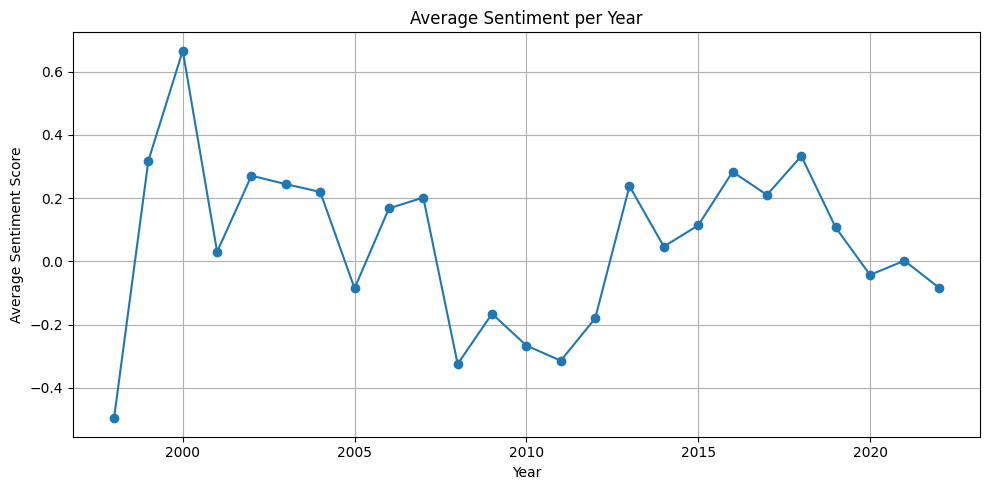

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(yearly_sentiment['Year'], yearly_sentiment['Sentiment'], marker='o')
plt.title('Average Sentiment per Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


**Group by Year and Author**

In [15]:
# Group by both Year and Author, calculate mean sentiment
author_year_sentiment = df.groupby(['Year', 'Author'])['Sentiment'].mean().reset_index()
author_year_sentiment 


,Year,Author,Sentiment
0,1998,Budd,-0.997400
1,1998,Buiter,0.995900
2,1998,George,-0.327867
3,1998,Governor,-0.999500
4,1998,King,-0.987700
...,...,...,...
436,2022,Sheppard,0.999900
437,2022,Stheeman,0.999300
438,2022,Tenreyro,-0.999900
439,2022,Wilkins,0.999800


In [16]:
# Create a pivot table for easier plotting
pivot_table = author_year_sentiment.pivot(index='Year', columns='Author', values='Sentiment')


C:\Users\elif.ozkol\AppData\Local\Temp\ipykernel_1420\1264267950.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


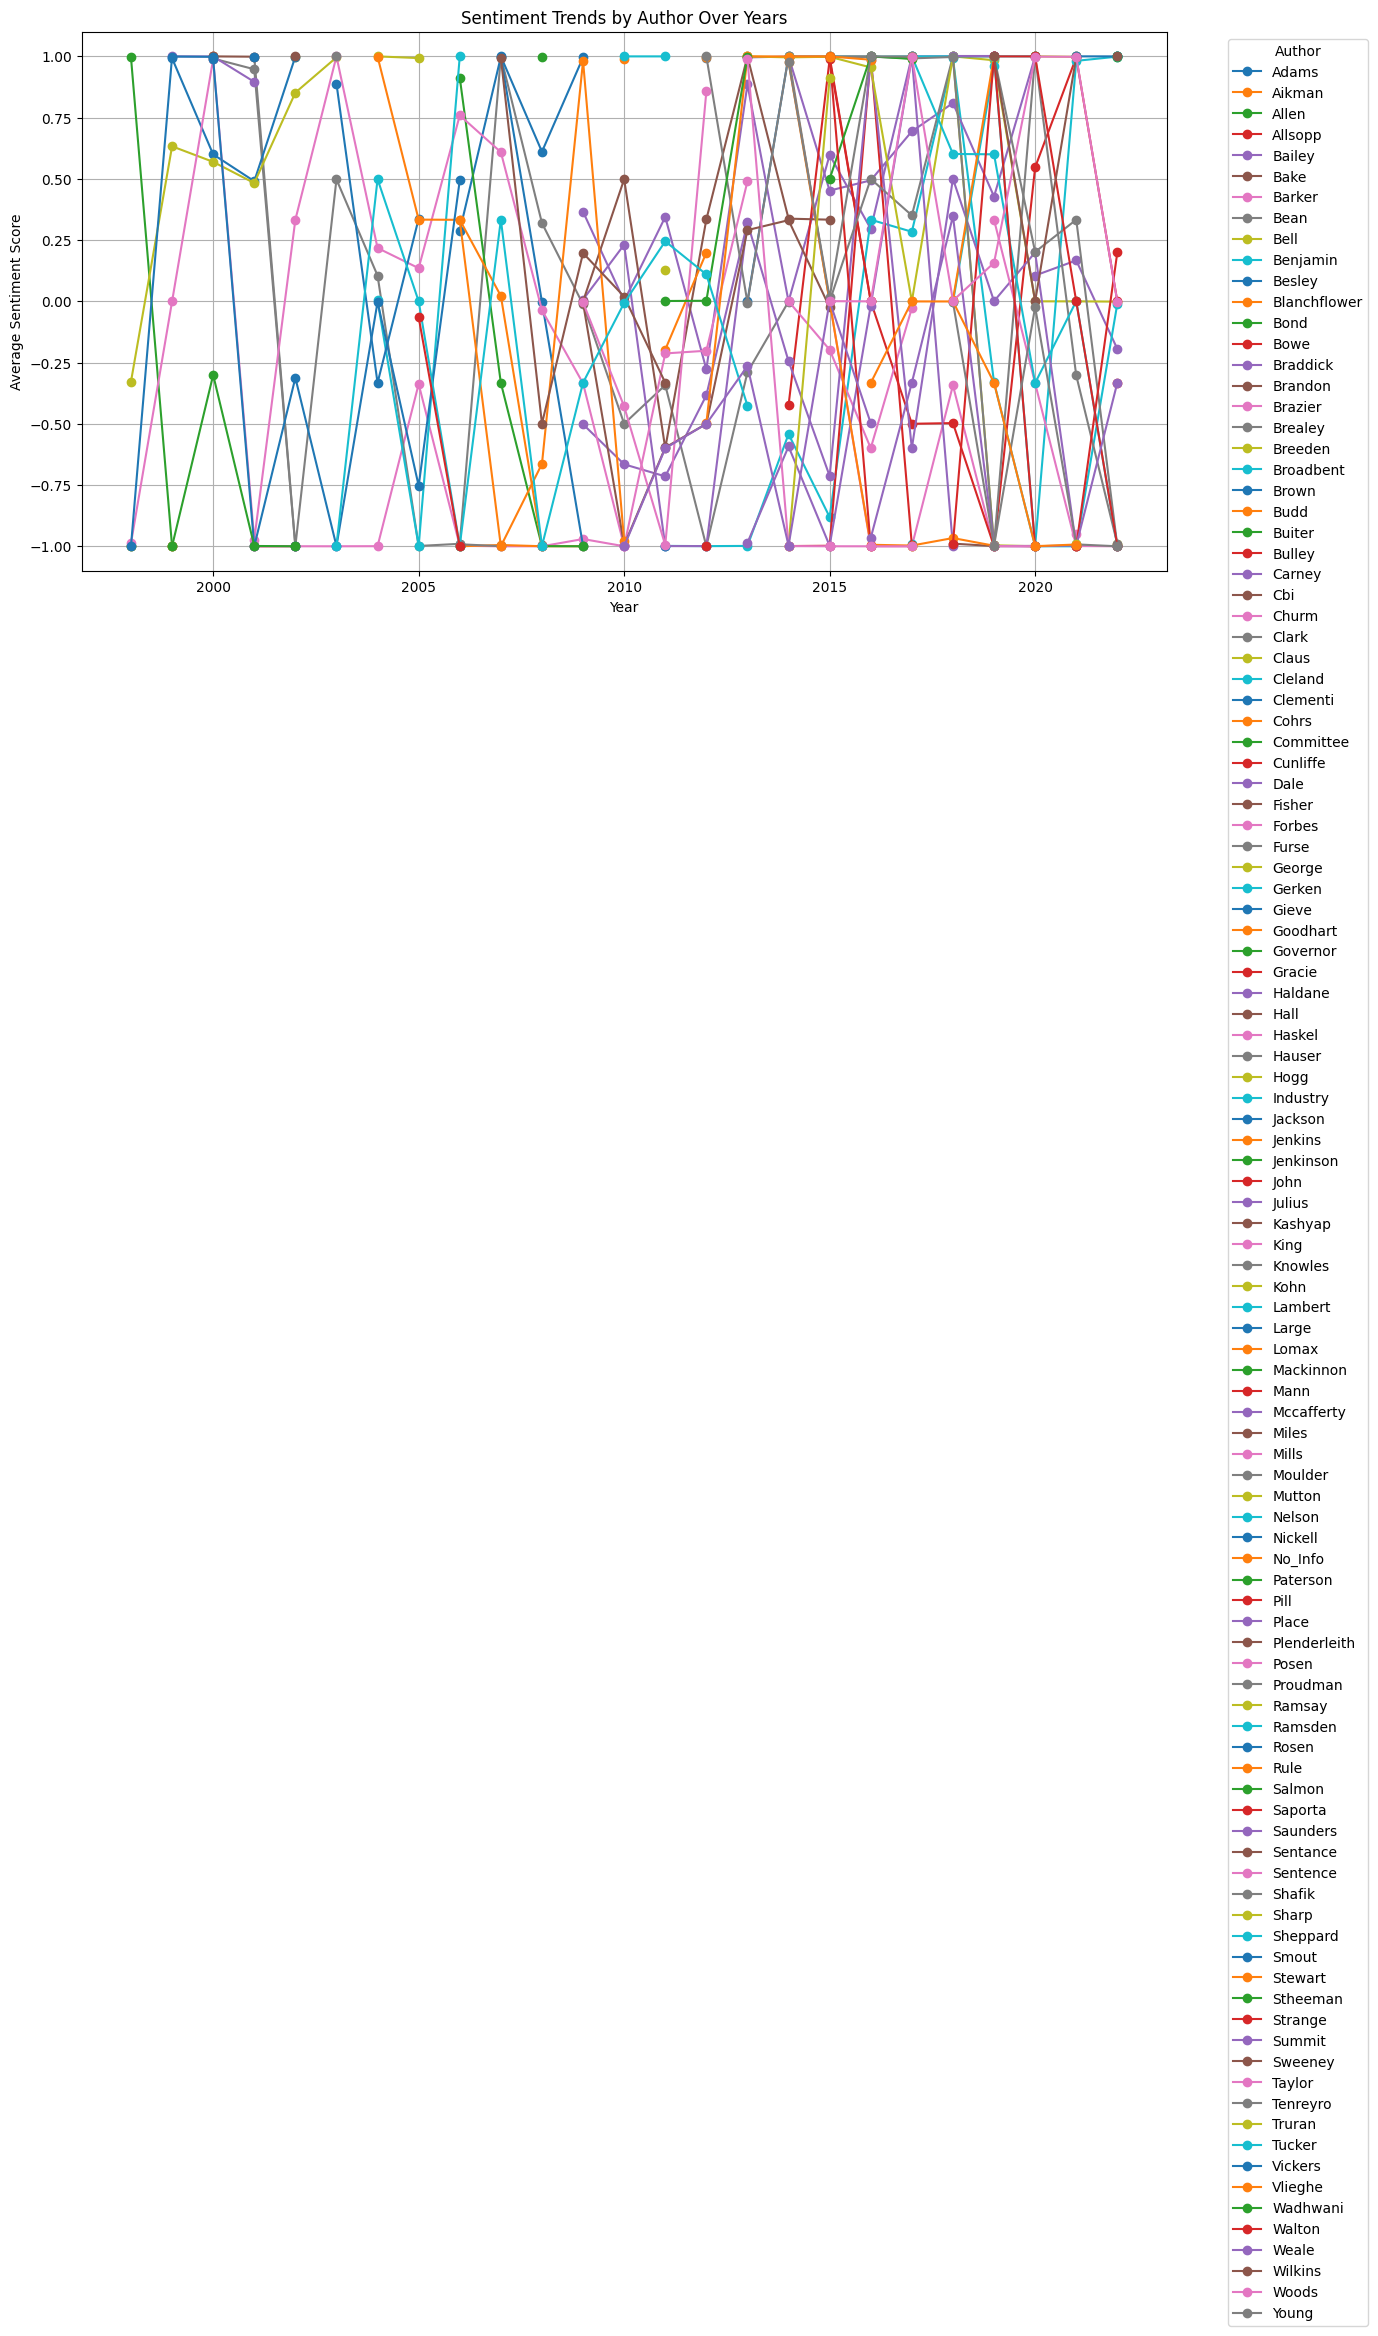

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for author in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[author], marker='o', label=author)

plt.title('Sentiment Trends by Author Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Filter only the selected authors
filtered_authors = ['George', 'Forbes', 'Haldane']

# Group by Year and Author
author_year_sentiment = df.groupby(['Year', 'Author'])['Sentiment'].mean().reset_index()

# Filter the grouped data
filtered_df = author_year_sentiment[author_year_sentiment['Author'].isin(filtered_authors)]

In [19]:
# Pivot for easier plotting
pivot_table = filtered_df.pivot(index='Year', columns='Author', values='Sentiment')


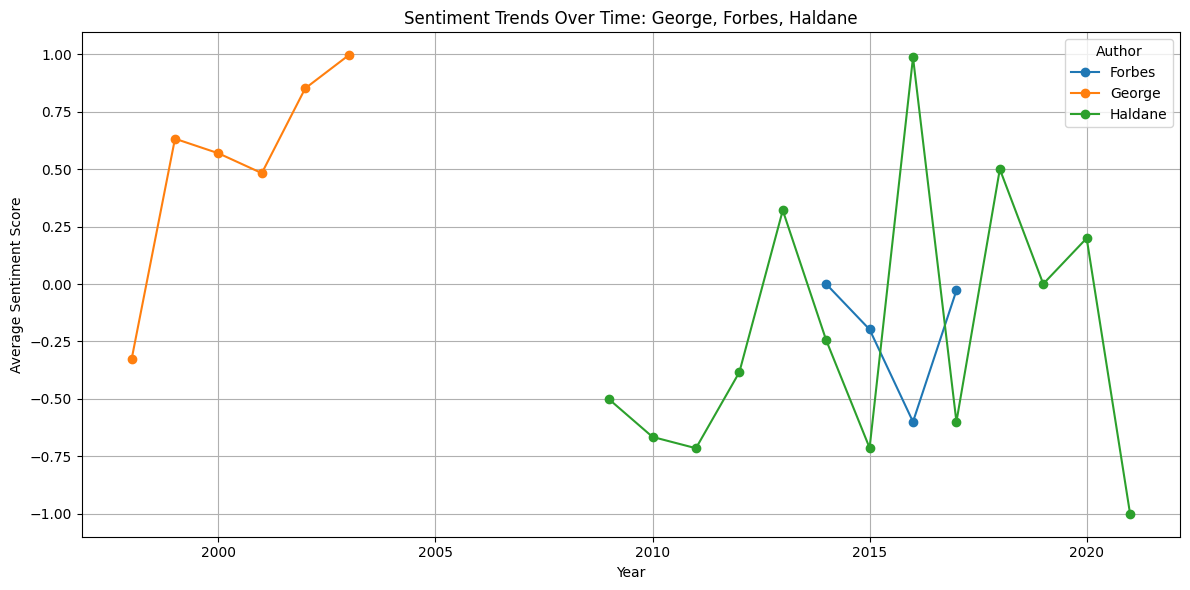

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for author in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[author], marker='o', label=author)

plt.title('Sentiment Trends Over Time: George, Forbes, Haldane')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Author')
plt.grid(True)
plt.tight_layout()
plt.show()
